In [7]:
%matplotlib notebook
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from pathlib import Path

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

In [8]:
def Matrix_Creator(Raw, Pixels):
    image_pair = []
    for k in range(0, len(Raw), Pixels*Pixels):
        blank = np.zeros((Pixels, Pixels))
        for i in range(Pixels):
            for j in range(Pixels):
                blank[i, j] = Raw[j + Pixels*i + k]
        image_pair.append(blank)
    return image_pair

def DataImport(path, extension, Pixels, NRaw):
    data = []
    eff_num = 0
    try:
        for i in range(1, NRaw + 1):
            step = "{}_{}.raw".format(extension, i)
            Raw = np.fromfile(path / Path(step), dtype='float32')
            matrix = Matrix_Creator(Raw, Pixels)
            data.append(matrix)
    except Exception as e:
        print("1. The dithering image {} has only {} beamruns.".format(path, i - 1))
        print("{}".format(e))
        eff_num = i - 1
        None
    
    try:
        step = "{}_FF.raw".format(extension)
        Raw = np.fromfile(path / Path(step), dtype='float32')
        matrix = Matrix_Creator(Raw, Pixels)
        data.append(matrix)
        print("2. A Flat Field has been found.")
    except FileNotFoundError:
        print("2. There is no Flat Field in this set.")
        None
        
    if eff_num == 0:
        eff_num = NRaw
    else:
        None
        
    return data, eff_num

def ImageGenerator(data, N_images, N_Dopple):
    images = [] 
    for i in range(0, N_images):
        mean = 0
        for j in range(0, N_Dopple):
            mean += data[i][j]
        mean = mean/N_Dopple
        images.append(mean)
        
    if len(data) > N_images:
        mean_ff = 0
        for j in range(0, N_Dopple):
            mean_ff += data[-1][j]
        mean_ff = mean_ff/N_Dopple
        images.append(mean_ff)
        print("2. A Flat Field has been found.")
    else:
        print("2. There is no Flat Field in this set.")
        
    return images

def IntensityMean(image, Pixels, cut):
    intensity = np.zeros(Pixels)
    for i in range(0, Pixels):
        intensity += image[i, 0:Pixels]
    intensity = intensity[cut:-cut]
    mean = intensity/np.max(intensity)
    return mean


def Aver(name,X1,X2,Step):
    P=np.copy(name)
    for i in range(len(P)):
        P[i,X1:X2]=(1/2)*(P[i,X1-Step:X2-Step]+P[i,X1+Step:X2+Step])
    return P

In [9]:
pixel = 256
n_typeCOL = 1
n_dithstep = 4
n_beamrun = 1
raw = "raw_"
txt = "txt"

In [10]:
directory = "Phantom"
variation = "50um"
extension = "Piece"

In [11]:
images = []
for i in range(1, n_dithstep + 1):
    print("----- Set #{} is being analyzed ------".format(i))
    number = str(i)
    path = Path(raw) / Path(directory) / Path(variation) / Path(number)
    data, eff_num = DataImport(path, extension, pixel, n_beamrun) 
    generated_images = ImageGenerator(data, eff_num, n_typeCOL + 1)
    image = np.zeros_like(generated_images[0])
    for k in generated_images:
        image += k
    images.append(image)
    print("----- Set #{} has been completely analyzed ------ \n".format(i))    

----- Set #1 is being analyzed ------
2. There is no Flat Field in this set.
2. There is no Flat Field in this set.
----- Set #1 has been completely analyzed ------ 

----- Set #2 is being analyzed ------
2. There is no Flat Field in this set.
2. There is no Flat Field in this set.
----- Set #2 has been completely analyzed ------ 

----- Set #3 is being analyzed ------
2. There is no Flat Field in this set.
2. There is no Flat Field in this set.
----- Set #3 has been completely analyzed ------ 

----- Set #4 is being analyzed ------
2. There is no Flat Field in this set.
2. There is no Flat Field in this set.
----- Set #4 has been completely analyzed ------ 



In [12]:
k = 0
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Intensity Map of Set {}".format(k + 1))
map_ = ax.imshow(images[k], cmap = "bone")
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

<IPython.core.display.Javascript object>

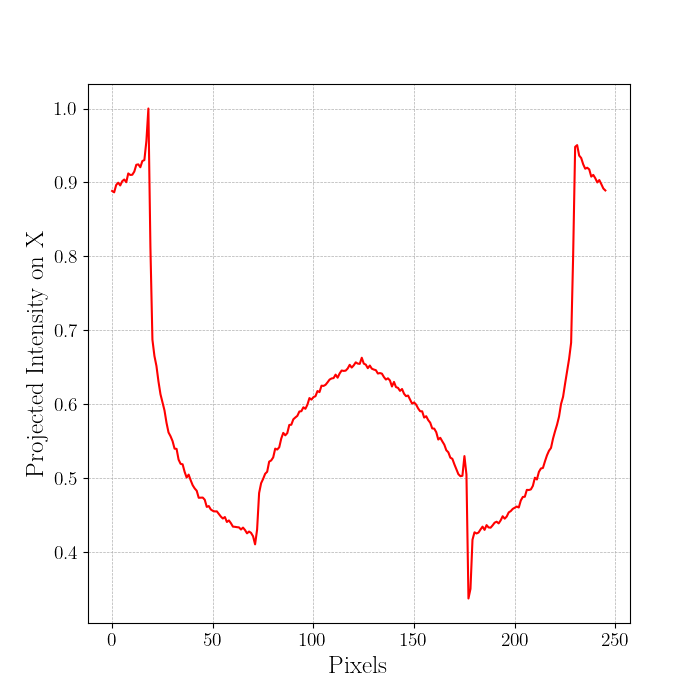

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = IntensityMean(images[k], pixel, 5)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

In [20]:
folder = variation.replace("\\", "")
look_for = "image_set\\{}\\{}\\".format(directory, folder)
try: 
    os.mkdir("image_set\\{}".format(directory))
    print("Directory succesfully created. \n")
except Exception as e:
    print("{}".format(e))
    
try:
    os.mkdir("image_set\\{}\\{}".format(directory, folder))
    print("The sub-directory was succesfully created. \n")
except Exception as e:
        print("{}".format(e))
    
for i in range(1, n_dithstep + 1):
    np.savetxt("image_set\\{}\\{}\\Frame_{}.txt".format(directory, folder, i), images[i - 1], fmt = "%.6f")

Directory succesfully created. 

The sub-directory was succesfully created. 



In [21]:
z_FS = 0.6 
z_SD = 1.2 
z_FD = z_FS + z_SD 
M = z_FD/z_FS
E_J = 20 
h=6.63*10**(-34)
c=3*(10**(8))
k=(2*np.pi*E_J)/(h*c)
o = k/z_SD

a =  31.6*(10**(-6))

In [22]:
txt_images = []
for i in range(1, n_dithstep + 1):
    image = np.genfromtxt("{}Frame_{}.txt".format(look_for, i))
    txt_images.append(image)

In [23]:
Odd_Maps = []
Even_Maps =[]
Absor_Maps = []
Phase_Maps = []

for i in range(0, n_dithstep): 
    odd = txt_images[i][:,1::2] 
    even = txt_images[i][:,::2]
    
    absor = (txt_images[i][:,::2] + txt_images[i][:,1::2])/2
    p_num = txt_images[i][:,1::2] - txt_images[i][:,::2]
    d_num = txt_images[i][:,1::2] + txt_images[i][:,::2]
    phase  = (M*a*o/2)*np.divide(p_num, d_num, out = np.ones_like(p_num)*10000000, where = d_num != 0)
    
    Odd_Maps.append(odd)
    Even_Maps.append(even)
    Absor_Maps.append(absor)
    Phase_Maps.append(phase)

In [24]:
Sep = int(pixel/2)
shortener = 5

Odd_Dith = np.zeros((pixel, n_dithstep*Sep))
Even_Dith = np.zeros((pixel, n_dithstep*Sep))
Absor_Dith = np.zeros((pixel, n_dithstep*Sep))
Phase_Dith = np.zeros((pixel, n_dithstep*Sep))

for i in range(0, n_dithstep):
    for j in range(0, int(pixel/2)):
        Odd_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Odd_Maps[n_dithstep - 1 - i][:,j:j + 1]
        Even_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Even_Maps[n_dithstep - 1 - i][:,j:j + 1]
        Absor_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Absor_Maps[n_dithstep - 1 - i][:,j:j + 1]
        Phase_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Phase_Maps[n_dithstep - 1 - i][:,j:j + 1]

Factor = Odd_Dith.shape[1]/Odd_Dith.shape[0]

Odd = zoom(Odd_Dith, (Factor, 1))
Even = zoom(Even_Dith, (Factor, 1))
Absor= zoom(Absor_Dith, (Factor, 1))
Phase = zoom(Phase_Dith, (Factor, 1))

Odd = Odd/np.max(Odd)
Even = Even/np.max(Even)
Absor = Absor/np.max(Absor)
Phase = Phase/np.max(Phase)

Total = (Even + Odd)/np.max(Even + Odd)

print(Total.shape)

I_Absor = IntensityMean(Absor, Absor.shape[0], shortener)
I_Phase = IntensityMean(Phase, Phase.shape[0], shortener)
I_Total = IntensityMean(Total, Total.shape[0], shortener)

(512, 512)


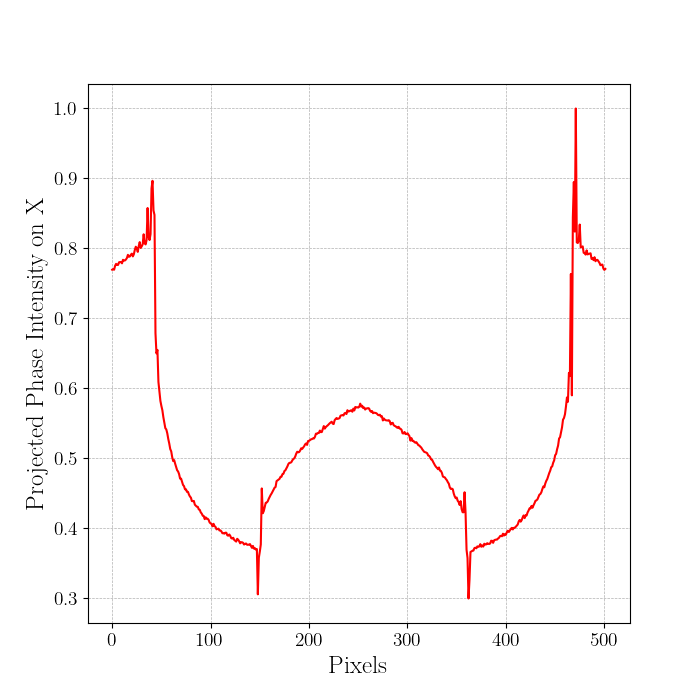

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(I_Absor, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Phase Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

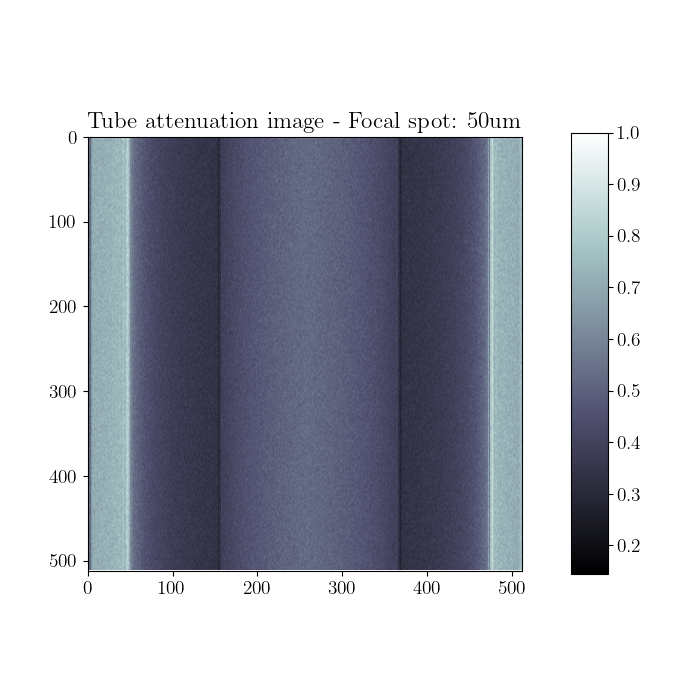

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(Absor, cmap = "bone")
ax.set_title("Tube attenuation image - Focal spot: {}".format(folder))
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)
#ax.plot(np.linspace(4, 508, 504), I_Absor*(500), '-', color="red")

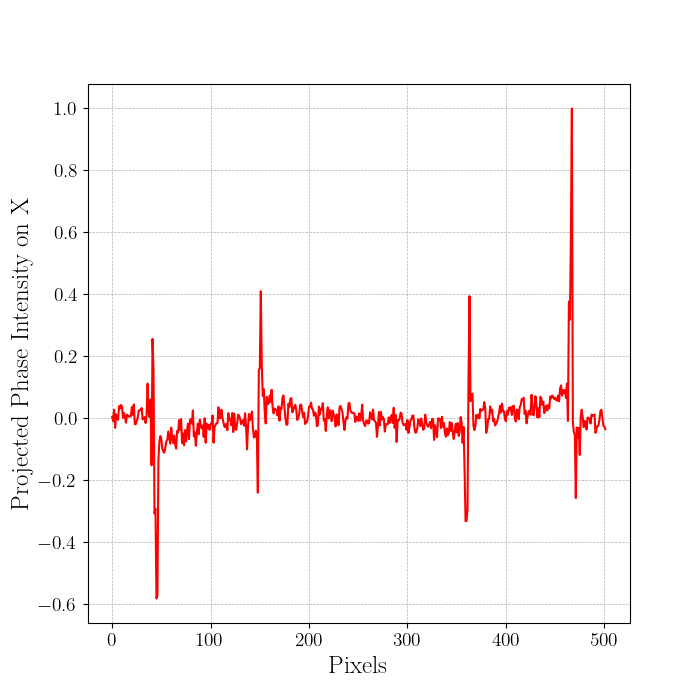

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(I_Phase, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Phase Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

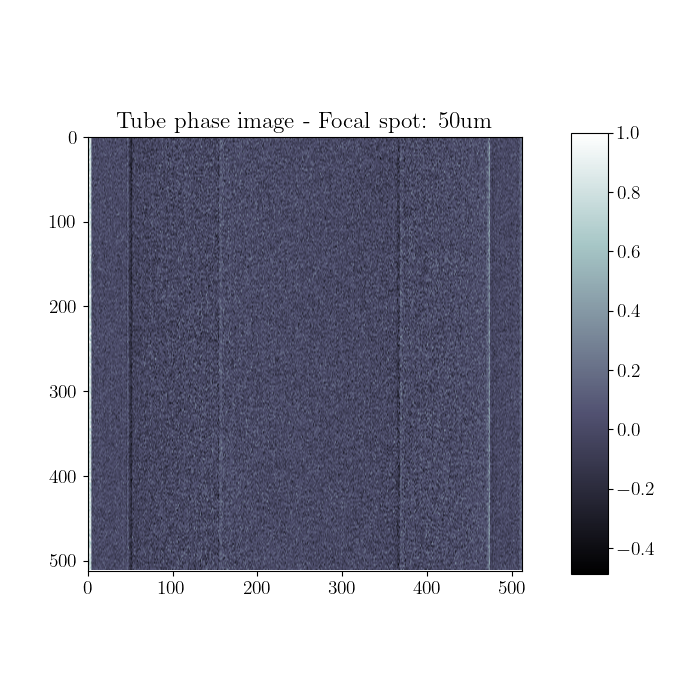

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(Phase, cmap = "bone")
ax.set_title("Tube phase image - Focal spot: {}".format(folder))
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)